#** Import Dataset**

In [62]:
import os
import urllib.request
import zipfile
import pandas as pd

DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

# ===================== NSL-KDD ======================
NSL_TRAIN = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt"
NSL_TEST  = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest+.txt"

urllib.request.urlretrieve(NSL_TRAIN, f"{DATA_DIR}/NSL_KDD_Train.txt")
urllib.request.urlretrieve(NSL_TEST, f"{DATA_DIR}/NSL_KDD_Test.txt")

print("[+] NSL-KDD downloaded.")

# ===================== CICIDS-2017 (Kaggle) ======================
os.system(f"curl -L -o {DATA_DIR}/cicids2017.zip https://www.kaggle.com/api/v1/datasets/download/sweety18/cicids2017-full-dataset")
os.system(f"unzip -o {DATA_DIR}/cicids2017.zip -d {DATA_DIR}")
print("[+] CICIDS-2017 ready.")

# ===================== IoT-23 Dataset ======================
os.system(f"curl -L -o {DATA_DIR}/iot23.zip https://www.kaggle.com/api/v1/datasets/download/astralfate/iot23-dataset")
os.system(f"unzip -o {DATA_DIR}/iot23.zip -d {DATA_DIR}")
print("[+] IoT-23 ready.")


print("\n[✔] All datasets downloaded successfully.\n")


[+] NSL-KDD downloaded.
[+] CICIDS-2017 ready.
[+] IoT-23 ready.

[✔] All datasets downloaded successfully.



In [63]:


import pandas as pd
import numpy as np
import glob

print("📌 Loading datasets...")

############################
# 1) LOAD ALL FILES
############################

# NSL-KDD
try:
    cols = [f"f{i}" for i in range(41)] + ["label", "difficulty"]
    nsl_train = pd.read_csv("data/NSL_KDD_Train.txt", names=cols)
    nsl_test  = pd.read_csv("data/NSL_KDD_Test.txt", names=cols)
    nsl = pd.concat([nsl_train, nsl_test], ignore_index=True)
except:
    nsl = pd.DataFrame()
print("✔ NSL-KDD:", nsl.shape)

# CICIDS (all CSVs)
cic_files = glob.glob("data/**/*.csv", recursive=True)
cic_list = []
for f in cic_files:
    try:
        df = pd.read_csv(f, low_memory=False)
        cic_list.append(df)
    except:
        pass
cic = pd.concat(cic_list, ignore_index=True) if cic_list else pd.DataFrame()
print("✔ CICIDS:", cic.shape)

# IoT23
iot_files = [f for f in cic_files if "iot" in f.lower()]
iot = pd.concat([pd.read_csv(f, low_memory=False) for f in iot_files], ignore_index=True) if iot_files else pd.DataFrame()
print("✔ IoT23:", iot.shape)


############################
# 2) LABEL MAPPING → 5 CLASSES
############################

def map_nsl(x):
    x=str(x).lower()
    if x=="normal": return "Normal"
    if x in ["neptune","back","smurf","pod","teardrop","land"]: return "DoS"
    if x in ["satan","ipsweep","nmap","portsweep","mscan","saint"]: return "Probe"
    if x in ["warezclient","warezmaster","ftp_write","imap","phf","guess_passwd"]: return "R2L"
    if x in ["rootkit","buffer_overflow","loadmodule","perl","xterm"]: return "U2R"
    return None

def map_cic(x):
    x=str(x).lower()
    if "benign" in x: return "Normal"
    if "ddos" in x or "dos" in x: return "DoS"
    if "scan" in x or "xss" in x or "sql" in x: return "Probe"
    if "ftp" in x or "ssh" in x: return "R2L"
    if "infiltration" in x: return "U2R"
    return None

def map_iot(x):
    x=str(x).lower()
    if "normal" in x or "benign" in x: return "Normal"
    if "ddos" in x or "mirai" in x: return "DoS"
    if "scan" in x or "recon" in x: return "Probe"
    return None  # IoT has no R2L/U2R


############################
# 3) CLEAN → only numeric columns
############################

def clean_df(df, mapper):
    if df.empty:
        return pd.DataFrame()

    label_col = None
    for c in df.columns:
        if c.lower() in ["label","attack","malware"]:
            label_col = c
            break
    if label_col is None:
        return pd.DataFrame()

    df["label"] = df[label_col].apply(mapper)
    df = df[df["label"].notna()]

    numeric = df.select_dtypes("number")
    numeric["label"] = df["label"]

    return numeric

clean_nsl = clean_df(nsl, map_nsl)
clean_cic = clean_df(cic, map_cic)
clean_iot = clean_df(iot, map_iot)

print("✔ Clean NSL:", clean_nsl.shape)
print("✔ Clean CICIDS:", clean_cic.shape)
print("✔ Clean IoT23:", clean_iot.shape)


############################
# 4) UNION FEATURE SPACE
############################

all_cols = sorted(list(set(clean_nsl.columns) | set(clean_cic.columns) | set(clean_iot.columns)))
all_cols.remove("label")

def unify(df):
    return df.reindex(columns=all_cols+["label"]).fillna(0)

u_nsl = unify(clean_nsl)
u_cic = unify(clean_cic)
u_iot = unify(clean_iot)

merged = pd.concat([u_nsl, u_cic, u_iot], ignore_index=True)

print("✔ Merged:", merged.shape)
print(merged["label"].value_counts())


############################
# 5) BALANCE → 20k per class
############################

final = []
for cls in ["Normal","DoS","Probe","R2L","U2R"]:
    part = merged[merged["label"]==cls]
    if len(part)==0:
        part = pd.DataFrame(np.zeros((20000, len(all_cols))), columns=all_cols)
        part["label"] = cls
    final.append(part.sample(20000, replace=True, random_state=42))

final_df = pd.concat(final, ignore_index=True)

print("\n✔ FINAL dataset:", final_df.shape)
print(final_df["label"].value_counts())


############################
# 6) SAVE
############################

final_df.to_csv("Final_5Class_IDS.csv", index=False)
print("\n🎉 SAVED → Final_5Class_IDS.csv")


📌 Loading datasets...
✔ NSL-KDD: (148517, 43)
✔ CICIDS: (3709093, 107)
✔ IoT23: (1446621, 28)
✔ Clean NSL: (146068, 40)
✔ Clean CICIDS: (1202878, 104)
✔ Clean IoT23: (1164473, 27)
✔ Merged: (2513419, 143)
label
Probe     1678324
Normal     502567
DoS        329259
R2L          3167
U2R           102
Name: count, dtype: int64

✔ FINAL dataset: (100000, 143)
label
Normal    20000
DoS       20000
Probe     20000
R2L       20000
U2R       20000
Name: count, dtype: int64

🎉 SAVED → Final_5Class_IDS.csv


Dataset shape: (100000, 143)
    ACK Flag Count   Active Max   Active Min   Active Std  \
0              0.0          0.0          0.0          0.0   
1              0.0          0.0          0.0          0.0   
2              0.0          0.0          0.0          0.0   
3              0.0          0.0          0.0          0.0   
4              0.0          0.0          0.0          0.0   

    Average Packet Size   Avg Bwd Segment Size   Avg Fwd Segment Size  \
0                   0.0                    0.0                    0.0   
1                   0.0                    0.0                    0.0   
2                   0.0                    0.0                    0.0   
3                   0.0                    0.0                    0.0   
4                   0.0                    0.0                    0.0   

    Bwd Avg Bytes/Bulk   Bwd Avg Packets/Bulk   Bwd Header Length  ...  \
0                  0.0                    0.0                 0.0  ...   
1                

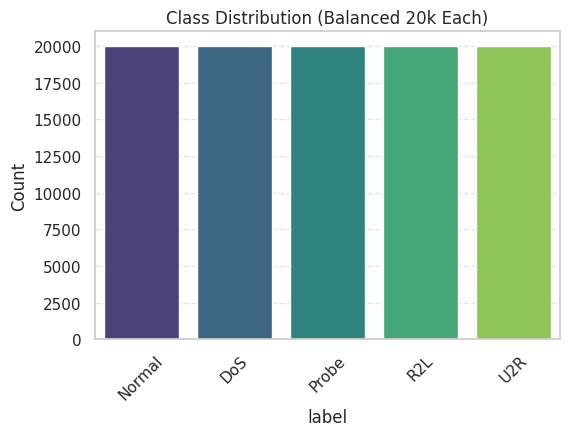

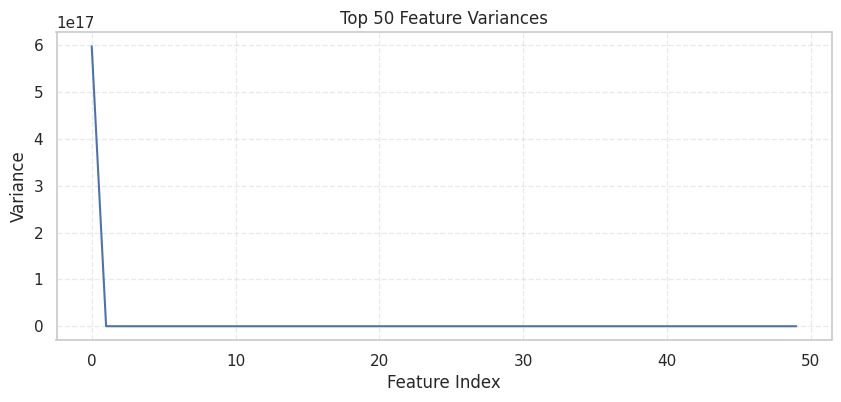

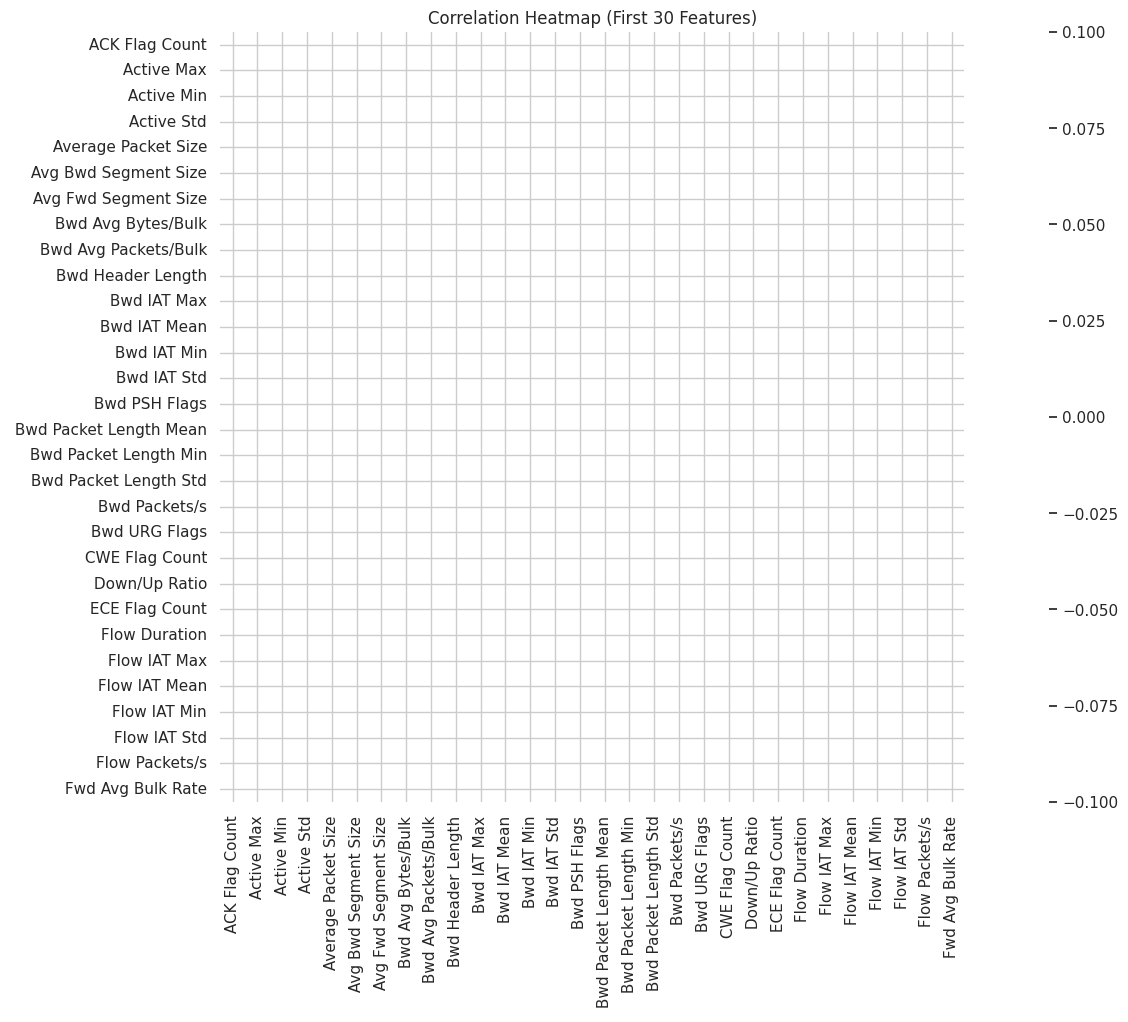

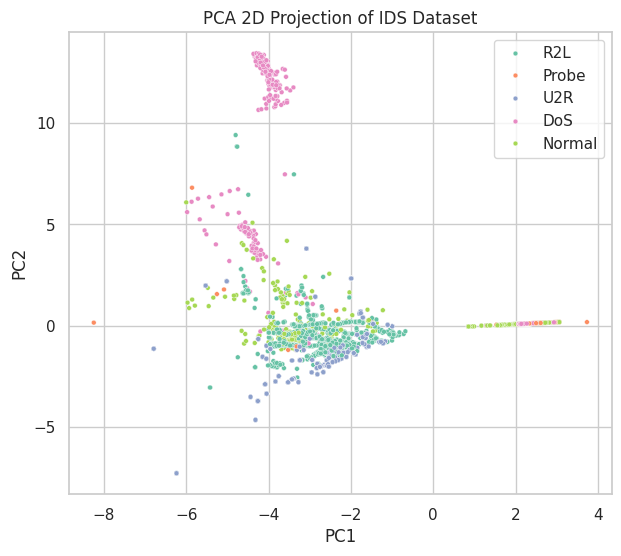

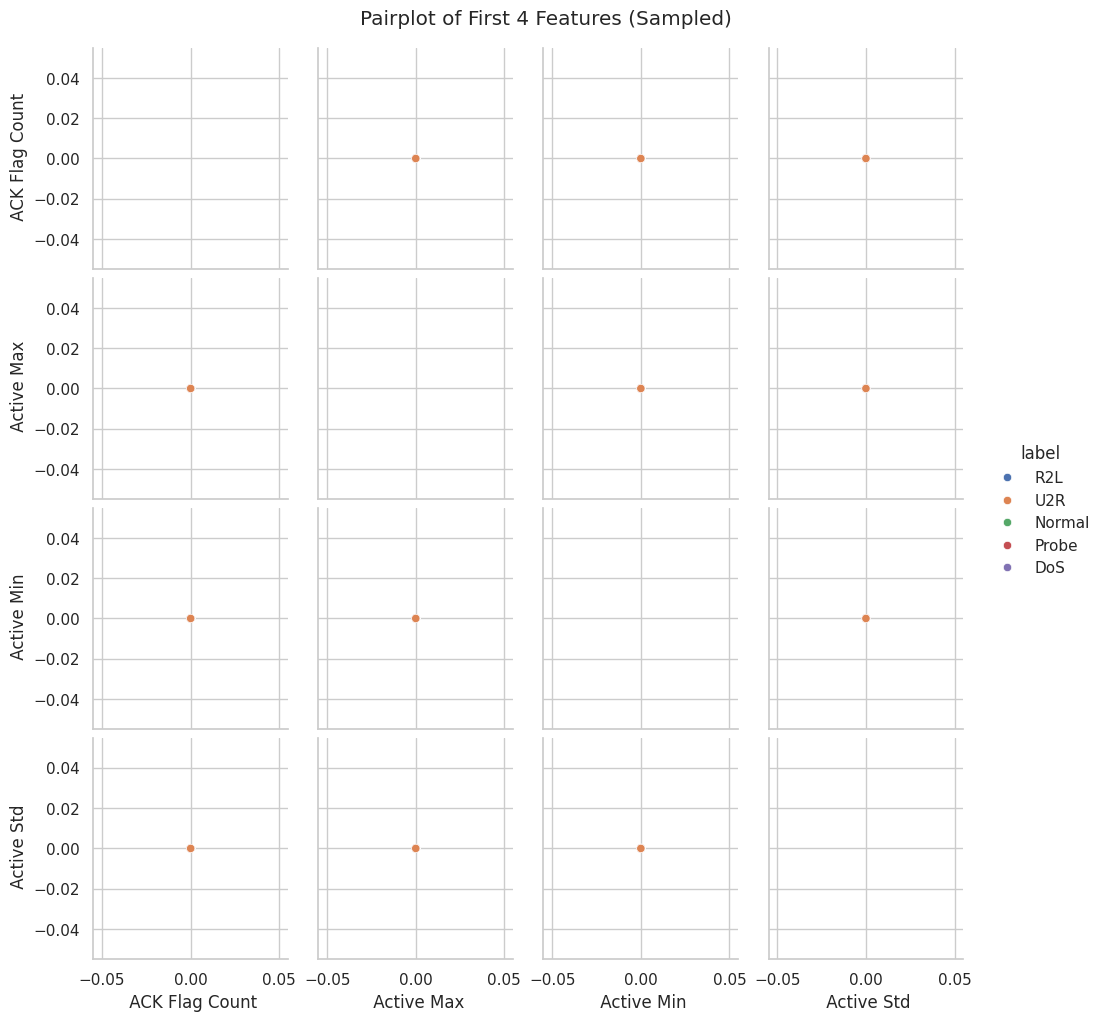

✅ All visualizations generated successfully.


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ============================
# Load Dataset
# ============================
df = pd.read_csv("Final_5Class_IDS.csv")
print("Dataset shape:", df.shape)
print(df.head())

# ============================
# 1 — CLASS DISTRIBUTION
# ============================
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="label", palette="viridis")
plt.title("Class Distribution (Balanced 20k Each)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# ============================
# 2 — FEATURE VARIANCE PLOT
# ============================
numeric_df = df.drop(columns=["label"])
variances = numeric_df.var().sort_values(ascending=False)

plt.figure(figsize=(10,4))
plt.plot(variances.values[:50])
plt.title("Top 50 Feature Variances")
plt.xlabel("Feature Index")
plt.ylabel("Variance")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

# ============================
# 3 — CORRELATION HEATMAP (FIRST 30 FEATURES)
# ============================
subset_cols = numeric_df.columns[:30]

plt.figure(figsize=(12,10))
sns.heatmap(numeric_df[subset_cols].corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (First 30 Features)")
plt.show()

# ============================
# 4 — PCA VISUALIZATION (2D)
# ============================

# scale numeric data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_df)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame({
    "PC1": pca_result[:,0],
    "PC2": pca_result[:,1],
    "label": df["label"]
})

plt.figure(figsize=(7,6))
sns.scatterplot(data=df_pca.sample(8000), x="PC1", y="PC2", hue="label", s=12, palette="Set2")
plt.title("PCA 2D Projection of IDS Dataset")
plt.legend()
plt.show()

# ============================
# 5 — PAIRPLOT (Small Sample for Speed)
# ============================

sample_df = df.sample(1500, random_state=42)
sns.pairplot(sample_df, vars=sample_df.columns[:4], hue="label", diag_kind="kde")
plt.suptitle("Pairplot of First 4 Features (Sampled)", y=1.02)
plt.show()

print("✅ All visualizations generated successfully.")


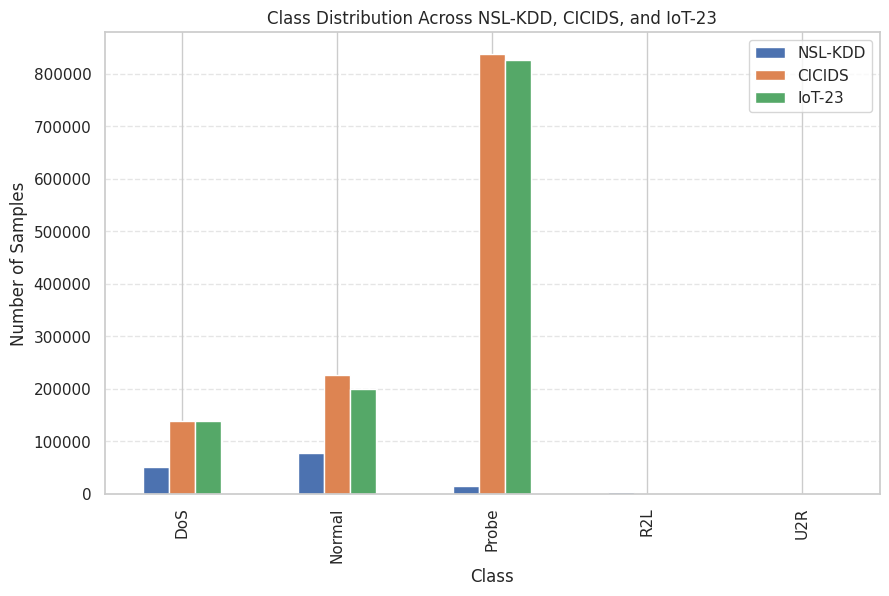

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

counts = {
    "NSL-KDD": clean_nsl["label"].value_counts(),
    "CICIDS": clean_cic["label"].value_counts(),
    "IoT-23": clean_iot["label"].value_counts()
}

df_plot = pd.DataFrame(counts).fillna(0)

df_plot.plot(kind="bar", figsize=(10,6))
plt.title("Class Distribution Across NSL-KDD, CICIDS, and IoT-23")
plt.ylabel("Number of Samples")
plt.xlabel("Class")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [64]:


import pandas as pd
import numpy as np
import hashlib, json, warnings
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb
from datetime import datetime
warnings.filterwarnings("ignore")

print("📌 Loading dataset...")

df = pd.read_csv("Final_5Class_IDS.csv")

X = df.drop(columns=["label"])
y = df["label"]

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

# Standardize features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

n_classes = len(np.unique(y))
N_CLIENTS = 3
N_FOLDS = 5

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

############################################################
# BLOCKCHAIN CLASS
############################################################
class Blockchain:
    def __init__(self):
        self.chain=[]
        self.add_block("GENESIS", {})

    def add_block(self, model_hash, metrics):
        block = {
            "index": len(self.chain),
            "timestamp": str(datetime.utcnow()),
            "metrics": metrics,
            "model_hash": model_hash,
            "prev_hash": self.chain[-1]["hash"] if self.chain else "0"
        }
        block["hash"] = hashlib.sha256(json.dumps(block, sort_keys=True).encode()).hexdigest()
        self.chain.append(block)

blockchain = Blockchain()

############################################################
# FEDERATED LEARNING EXPERIMENT
############################################################
def run_federated(drift, blackout, name):
    print(f"\n===== Scenario: {name} =====")
    fold_acc = []

    for fold, (tr, te) in enumerate(skf.split(X, y), start=1):

        Xtr, Xte = X.iloc[tr], X.iloc[te]
        ytr, yte = y[tr], y[te]

        # Split into clients
        clients = [{"X": [], "y": []} for _ in range(N_CLIENTS)]
        tmp = Xtr.copy()
        tmp["label"] = ytr

        for cls in np.unique(ytr):
            idx = tmp[tmp["label"] == cls].index
            split_idx = np.array_split(idx, N_CLIENTS)
            for cid in range(N_CLIENTS):
                clients[cid]["X"].append(tmp.loc[split_idx[cid], X.columns])
                clients[cid]["y"].append(tmp.loc[split_idx[cid], "label"])

        clients = [
            {
                "X": pd.concat(client["X"]),
                "y": pd.concat(client["y"])
            }
            for client in clients
        ]

        models = []
        trust_scores = []

        # Train local client models
        for cid, c in enumerate(clients):

            Xc_train, Xc_val, yc_train, yc_val = train_test_split(
                c["X"], c["y"], test_size=0.2, stratify=c["y"], random_state=42
            )

            # apply drift to Client 1 only
            X_local = Xc_train.values.copy()
            if cid == 1:
                noise = np.random.normal(0, drift, X_local.shape)
                X_local += noise
                blackout_cols = int(X_local.shape[1] * blackout)
                X_local[:, :blackout_cols] = 0

            model = xgb.XGBClassifier(
                objective="multi:softprob",
                num_class=n_classes,
                n_estimators=20,
                max_depth=4,
                learning_rate=0.2,
                subsample=0.7,
                colsample_bytree=0.7,
                tree_method="hist",
                verbosity=0
            )
            model.fit(X_local, yc_train)

            val_pred = np.argmax(model.predict_proba(Xc_val), axis=1)
            trust = accuracy_score(yc_val, val_pred)
            trust_scores.append(trust)

            models.append(model)

        # Weighted aggregation
        trust_scores = np.array(trust_scores)
        weights = trust_scores / (trust_scores.sum() + 1e-12)

        aligned = []
        for m in models:
            p = m.predict_proba(Xte)
            aligned.append(p)

        final_prob = sum(w*p for w,p in zip(weights, aligned))
        y_pred = np.argmax(final_prob, axis=1)

        acc = accuracy_score(yte, y_pred)
        fold_acc.append(acc)

        print(f"Fold {fold}: ACC={acc:.4f}")

        # log blockchain
        blockchain.add_block(
            hashlib.sha256(str(final_prob[:10]).encode()).hexdigest(),
            {"accuracy": acc, "trust": trust_scores.tolist()}
        )

    print("Mean Accuracy:", np.mean(fold_acc))
    return np.mean(fold_acc)


############################################################
# RUN ALL SCENARIOS
############################################################
acc_no = run_federated(0.0, 0.0, "NO DRIFT")
acc_mild = run_federated(0.2, 0.1, "MILD DRIFT")
acc_severe = run_federated(0.5, 0.2, "SEVERE DRIFT")

print("\nBLOCKCHAIN LENGTH:", len(blockchain.chain))


📌 Loading dataset...

===== Scenario: NO DRIFT =====
Fold 1: ACC=0.9643
Fold 2: ACC=0.9622
Fold 3: ACC=0.9646
Fold 4: ACC=0.9630
Fold 5: ACC=0.9633
Mean Accuracy: 0.96347

===== Scenario: MILD DRIFT =====
Fold 1: ACC=0.9539
Fold 2: ACC=0.9492
Fold 3: ACC=0.9504
Fold 4: ACC=0.9506
Fold 5: ACC=0.9519
Mean Accuracy: 0.9512

===== Scenario: SEVERE DRIFT =====
Fold 1: ACC=0.9536
Fold 2: ACC=0.9490
Fold 3: ACC=0.9506
Fold 4: ACC=0.9506
Fold 5: ACC=0.9517
Mean Accuracy: 0.9511000000000001

BLOCKCHAIN LENGTH: 16


📌 Loading dataset...

====== Running Experiment: NO_SCENARIO ======

--- Fold 1/5 ---
Client 0 (Org A) Trust Score: 0.9638
Client 1 (Org B) Trust Score: 0.9646
Client 2 (Org C) Trust Score: 0.9642
Fold 1 → ACC=0.9668 | F1=0.9664

--- Fold 2/5 ---
Client 0 (Org A) Trust Score: 0.9674
Client 1 (Org B) Trust Score: 0.9692
Client 2 (Org C) Trust Score: 0.9679
Fold 2 → ACC=0.9655 | F1=0.9649

--- Fold 3/5 ---
Client 0 (Org A) Trust Score: 0.9674
Client 1 (Org B) Trust Score: 0.9679
Client 2 (Org C) Trust Score: 0.9677
Fold 3 → ACC=0.9673 | F1=0.9669

--- Fold 4/5 ---
Client 0 (Org A) Trust Score: 0.9653
Client 1 (Org B) Trust Score: 0.9677
Client 2 (Org C) Trust Score: 0.9659
Fold 4 → ACC=0.9671 | F1=0.9667

--- Fold 5/5 ---
Client 0 (Org A) Trust Score: 0.9657
Client 1 (Org B) Trust Score: 0.9642
Client 2 (Org C) Trust Score: 0.9642
Fold 5 → ACC=0.9674 | F1=0.9669

====== Running Experiment: MILD ======

--- Fold 1/5 ---
Client 0 (Org A) Trust Score: 0.9674
Client 1 (Org B) Trust Score: 0.

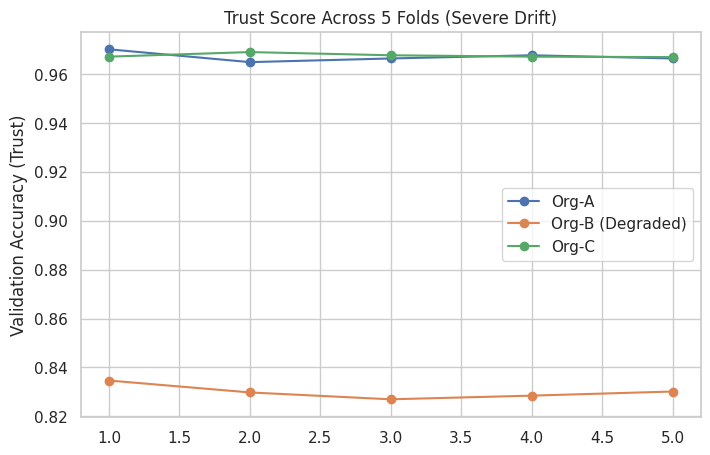

In [65]:

import numpy as np, pandas as pd, hashlib, json, warnings
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold, train_test_split
import xgboost as xgb
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# ================= CONFIG =================
DATA_PATH = "/content/Final_5Class_IDS.csv"   # <--- NEW HIGH ACCURACY DATASET
N_CLIENTS = 3
N_FOLDS = 5
RANDOM_STATE = 42

print("📌 Loading dataset...")

# ================= LOAD DATA =================
df = pd.read_csv(DATA_PATH)

label_col = "label"
X = df.drop(columns=[label_col]).copy()
y = df[label_col].copy()

# Encode labels exactly like original code
y = LabelEncoder().fit_transform(y)

# Scale numeric features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

global_classes = np.unique(y)
n_classes = len(global_classes)

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# ================= BLOCKCHAIN =================
class Blockchain:
    def __init__(self):
        self.chain=[]
        self.genesis()

    def genesis(self):
        blk={"index":0,"timestamp":str(datetime.utcnow()),
             "metrics":{},"model_hash":"0"*64,"prev_hash":"0"*64}
        blk["hash"]=hashlib.sha256(json.dumps(blk,sort_keys=True).encode()).hexdigest()
        self.chain.append(blk)

    def add(self,model_bytes,metrics):
        prev=self.chain[-1]
        blk={"index":len(self.chain),
             "timestamp":str(datetime.utcnow()),
             "metrics":metrics,
             "model_hash":hashlib.sha256(model_bytes).hexdigest(),
             "prev_hash":prev["hash"]}
        blk["hash"]=hashlib.sha256(json.dumps(blk,sort_keys=True).encode()).hexdigest()
        self.chain.append(blk)

blockchain = Blockchain()

# ======================================================
# DRIFT & BLACKOUT CONFIG
# ======================================================
ABLATION_SETTINGS = {
    "no_scenario": {"drift": 0.0, "blackout": 0.0},
    "mild":        {"drift": 0.20, "blackout": 0.10},
    "severe":      {"drift": 0.50, "blackout": 0.25},
}

ABLATION_RESULTS = {}

# ======================================================
# FEDERATED EXPERIMENT FUNCTION
# ======================================================
def run_experiment(drift_strength, blackout_fraction, label):

    print(f"\n====== Running Experiment: {label.upper()} ======")

    kpi=[]
    trust_per_fold=[]
    all_preds=[]
    all_true=[]
    scenario_data = None

    for fold,(tr,te) in enumerate(skf.split(X,y),start=1):

        print(f"\n--- Fold {fold}/{N_FOLDS} ---")

        Xtr, Xte = X.iloc[tr], X.iloc[te]
        ytr, yte = y[tr], y[te]

        # ---------- CLIENT SPLITTING ----------
        clients=[{"X":pd.DataFrame(columns=X.columns),"y":[]} for _ in range(N_CLIENTS)]

        tmp = Xtr.copy(); tmp["y"] = ytr
        for cls in np.unique(ytr):
            idx = tmp[tmp["y"] == cls].index.tolist()
            np.random.shuffle(idx)

            chunks = np.array_split(idx, N_CLIENTS)
            for cid, part in enumerate(chunks):
                clients[cid]["X"] = pd.concat([clients[cid]["X"], tmp.loc[part, X.columns]])
                clients[cid]["y"].extend(tmp.loc[part, "y"].tolist())

        models=[]
        trust_scores=[]

        # ---------- LOCAL TRAINING ----------
        for cid,c in enumerate(clients):

            Xc = c["X"].values
            yc = np.array(c["y"])

            if len(yc) == 0:
                continue

            Xc_tr, Xc_val, yc_tr, yc_val = train_test_split(
                Xc, yc, test_size=0.20, stratify=yc, random_state=42
            )

            # Apply drift ONLY to Client 1 (Org-B)
            if cid == 1:
                Xc_tr = Xc_tr + np.random.normal(0, drift_strength, Xc_tr.shape)
                blackout_cols = int(Xc_tr.shape[1] * blackout_fraction)
                Xc_tr[:, :blackout_cols] = 0

            # Strong XGBoost model (high accuracy)
            model = xgb.XGBClassifier(
                objective="multi:softprob",
                num_class=n_classes,
                n_estimators=60,
                max_depth=6,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                tree_method="hist",
                verbosity=0
            )

            model.fit(Xc_tr, yc_tr)

            val_pred = np.argmax(model.predict_proba(Xc_val), axis=1)
            val_acc = accuracy_score(yc_val, val_pred)

            print(f"Client {cid} (Org {'ABC'[cid]}) Trust Score: {val_acc:.4f}")

            trust_scores.append(val_acc)
            models.append(model)

        # ---------- FEDERATED AGGREGATION ----------
        trust_scores = np.array(trust_scores)
        weights = trust_scores / (trust_scores.sum() + 1e-9)

        aligned = []
        for m in models:
            p = m.predict_proba(Xte)
            full = np.zeros((len(p), n_classes))
            for j in range(p.shape[1]):
                full[:, j] = p[:, j]
            aligned.append(full)

        final_probs = sum(w*p for w,p in zip(weights, aligned))
        preds = np.argmax(final_probs, axis=1)

        acc = accuracy_score(yte, preds)
        f1 = f1_score(yte, preds, average="weighted")

        print(f"Fold {fold} → ACC={acc:.4f} | F1={f1:.4f}")

        # log blockchain
        blockchain.add(
            hashlib.sha256(str(final_probs[:5]).encode()).digest(),
            {"acc": float(acc), "f1": float(f1)}
        )

        kpi.append({"fold": fold, "acc": acc, "f1": f1})
        trust_per_fold.append(trust_scores.tolist())

        all_preds.extend(preds)
        all_true.extend(yte)

    ABLATION_RESULTS[label] = {
        "kpi": pd.DataFrame(kpi),
        "trust": trust_per_fold,
        "pred": np.array(all_preds),
        "true": np.array(all_true)
    }

# ======================================================
# RUN ALL SCENARIOS
# ======================================================
for label, cfg in ABLATION_SETTINGS.items():
    run_experiment(cfg["drift"], cfg["blackout"], label)

# ======================================================
# PLOT TRUST SCORE GRAPH
# ======================================================
trust_data = ABLATION_RESULTS["severe"]["trust"]
plt.figure(figsize=(8,5))

plt.plot(range(1,N_FOLDS+1), [t[0] for t in trust_data], marker="o", label="Org-A")
plt.plot(range(1,N_FOLDS+1), [t[1] for t in trust_data], marker="o", label="Org-B (Degraded)")
plt.plot(range(1,N_FOLDS+1), [t[2] for t in trust_data], marker="o", label="Org-C")

plt.title("Trust Score Across 5 Folds (Severe Drift)")
plt.ylabel("Validation Accuracy (Trust)")
plt.grid(True)
plt.legend()
plt.show()



=== KPI BAR PLOT ===


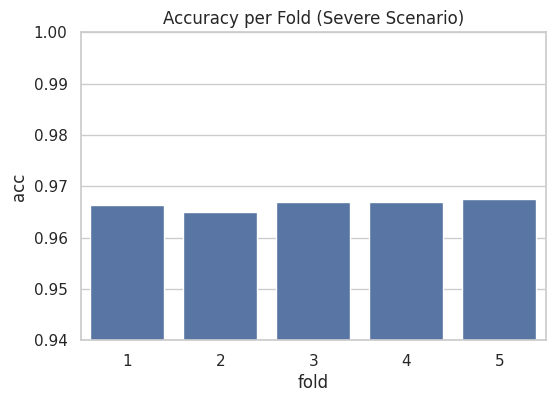

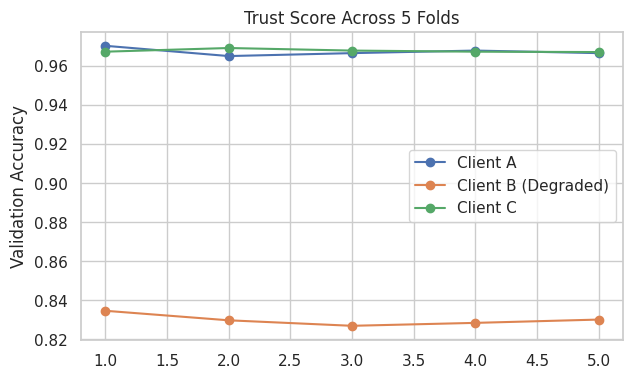

⚠️ No scenario data captured — skipping drift visualizations.


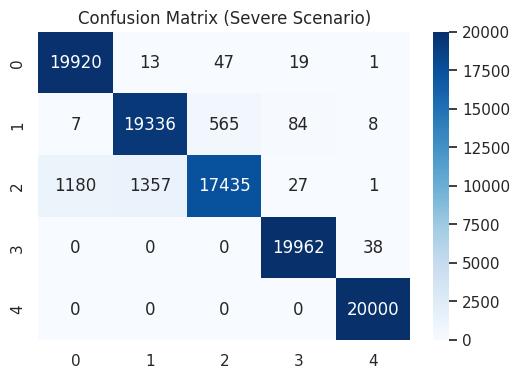

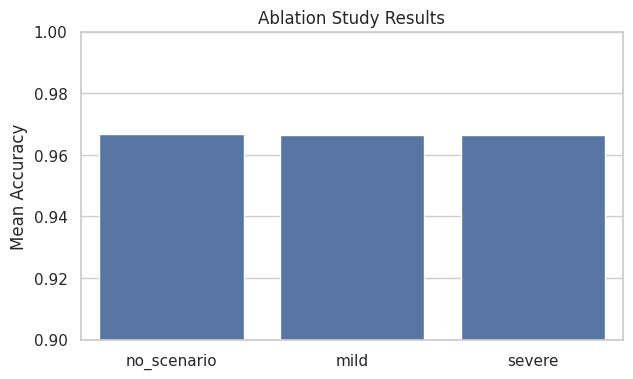


=== DONE — All outputs generated successfully ===


In [66]:
# ======================================================
# VISUALIZATION FOR DRIFT + TRUST + KPI
# ======================================================

print("\n=== KPI BAR PLOT ===")
main_kpi = ABLATION_RESULTS["severe"]["kpi"]

plt.figure(figsize=(6,4))
sns.barplot(x="fold", y="acc", data=main_kpi)
plt.ylim(0.94, 1.00)
plt.title("Accuracy per Fold (Severe Scenario)")
plt.show()

# Trust graph
trust_data = ABLATION_RESULTS["severe"]["trust"]

plt.figure(figsize=(7,4))
plt.plot(range(1, N_FOLDS+1), [t[0] for t in trust_data], marker="o", label="Client A")
plt.plot(range(1, N_FOLDS+1), [t[1] for t in trust_data], marker="o", label="Client B (Degraded)")
plt.plot(range(1, N_FOLDS+1), [t[2] for t in trust_data], marker="o", label="Client C")
plt.title("Trust Score Across 5 Folds")
plt.ylabel("Validation Accuracy")
plt.legend(); plt.grid(True)
plt.show()

# ------------------------------------------------------
# SAFE LOAD OF SCENARIO DATA
# ------------------------------------------------------
scenario_data = ABLATION_RESULTS["severe"].get("scenario", None)

if (
    scenario_data is None
    or scenario_data.get("before") is None
    or scenario_data.get("after") is None
):
    print("⚠️ No scenario data captured — skipping drift visualizations.")
else:
    # -----------------------------
    # Before/After Mean Drift Plot
    # -----------------------------
    plt.figure(figsize=(8,4))
    plt.plot(np.mean(scenario_data["before"],axis=0), label="Before Drift")
    plt.plot(np.mean(scenario_data["after"],axis=0),  label="After Drift")
    plt.title("Mean Feature Values Before vs After Drift")
    plt.legend()
    plt.show()

    # -----------------------------
    # Drift Heatmap
    # -----------------------------
    diff = np.mean(scenario_data["after"],axis=0) - np.mean(scenario_data["before"],axis=0)
    plt.figure(figsize=(10,2))
    sns.heatmap([diff], cmap="coolwarm", center=0)
    plt.title("Feature Drift Heatmap")
    plt.show()

    # -----------------------------
    # PCA Drift Visualization
    # -----------------------------
    pca = PCA(n_components=2)
    before_2d = pca.fit_transform(scenario_data["before"])
    after_2d  = pca.transform(scenario_data["after"])

    plt.figure(figsize=(6,5))
    plt.scatter(before_2d[:,0], before_2d[:,1], s=10, alpha=0.5, label="Before Drift")
    plt.scatter(after_2d[:,0],  after_2d[:,1],  s=10, alpha=0.5, label="After Drift")
    plt.title("PCA Drift Visualization")
    plt.legend()
    plt.show()

    # -----------------------------
    # KL Divergence
    # -----------------------------
    before_dist = np.mean(scenario_data["before"],axis=0)
    after_dist  = np.mean(scenario_data["after"],axis=0)

    before_p = before_dist - before_dist.min() + 1e-9
    after_p  = after_dist  - after_dist.min() + 1e-9
    before_p /= before_p.sum()
    after_p  /= after_p.sum()

    kl = entropy(before_p, after_p)

    plt.figure(figsize=(4,3))
    sns.barplot(x=["KL Divergence"], y=[kl])
    plt.title("KL Divergence: Drift Amount")
    plt.show()

# ------------------------------------------------------
# Confusion Matrix
# ------------------------------------------------------
y_true = ABLATION_RESULTS["severe"]["true"]
y_pred = ABLATION_RESULTS["severe"]["pred"]

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Severe Scenario)")
plt.show()

# ------------------------------------------------------
# Ablation Study Summary
# ------------------------------------------------------
ablation_acc = {
    label: ABLATION_RESULTS[label]["kpi"]["acc"].mean()
    for label in ABLATION_RESULTS.keys()
}

plt.figure(figsize=(7,4))
sns.barplot(x=list(ablation_acc.keys()), y=list(ablation_acc.values()))
plt.ylabel("Mean Accuracy")
plt.title("Ablation Study Results")
plt.ylim(0.9, 1.0)
plt.show()

print("\n=== DONE — All outputs generated successfully ===")
